# Building a gene network from the IDR and STRINGdb

This notebook exemplifies how to build Figure 1 of the paper using the IDR API. 

### Dependencies

 * [Matplotlib](http://matplotlib.org/)
 * [NumPy](http://www.numpy.org/)
 * [Pandas](http://pandas.pydata.org/)
 * [NetworkX](https://networkx.github.io/)
 * [Py2Cytoscape](https://pypi.python.org/pypi/py2cytoscape)
 * [Requests](http://docs.python-requests.org/)

In [1]:
import omero
from idr import connection

import requests
from pandas import DataFrame
from pandas import read_csv
from pandas import concat
from io import StringIO

from py2cytoscape.data.cyrest_client import CyRestClient
import py2cytoscape.util.dataframe as cydf
import numpy as np
from IPython.display import Image,display
import py2cytoscape.cytoscapejs as renderer

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, output_notebook, show,save
from bokeh.models import HoverTool

output_notebook()

<IPython.core.display.Javascript object>

Loading BokehJS ...

### Method definitions

In [2]:
def getBulkAnnotationAsDf(screenID,conn):
#    ofId=8118685
    sc=conn.getObject('Screen',screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName()=='bulk_annotations'):
                if (ann.getFile().getSize()> 147625090): #about 140Mb?
                    print "that's a big file..."
                    return None
                ofId=ann.getFile().getId()
                break

    print ofId
    original_file = omero.model.OriginalFileI(ofId, False)

    openTable = conn.c.sf.sharedResources().openTable(original_file)
    rowCount = openTable.getNumberOfRows()

    #table to df

    column_names = [col.name for col in openTable.getHeaders()]

    black_list = []
    column_indices = []
    for column_name in column_names:
        if column_name in black_list:
            continue
        column_indices.append(column_names.index(column_name))

    table_data = openTable.slice(column_indices, None)
    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn=DataFrame(data)
    dfAnn.columns=column_names
    return dfAnn


In [3]:
def getGenesFromPhenotype(df,phTerm):
# all gene from bulk_annotation 'df' annotated with CMPO term 'phTerm'
    colElong=[]
    for col in df.columns:
        if ('Term Accession' in col):
            if (phTerm in df[col].unique()):
                colElong.append(col)

    dfElong=concat([df[df[col]!= ''] for col in colElong])
    return dfElong['Gene Identifier'].unique()
    

### Connect to the IDR server

In [4]:
conn = connection()

## Querying the IDR

We will download the annotations for the three screens under study as panda DataFrames, and sub-select the genes from each which are annotated with the phenotype we are looking for, CMPO_0000077 a.k.a. 'elongated cell phenotype'.

The next step is to build, from that list, a list of IDs we can query the STRING database with. The translation table was built offline using biomart and pombase. 

In [5]:
#CMPO term to look for
phTerm = 'CMPO_0000077'

# ids of screens:
# scId = 3  # Graml et al.
# scId = 206  # Rohn et al., B
# scId = 1202  # Fuchs et al., B

screens = [3, 206, 1202]

genes=[]
for scId in screens:
    print 'loading '+str(scId)

    # loading bulk_annotations of screens as dataframes
    df = getBulkAnnotationAsDf(scId, conn)
    
    # unique genes with CPMO term
    cur = getGenesFromPhenotype(df, phTerm)
    print 'got ' + str(len(cur)) + ' genes'
    genes.extend(cur)

loading 3
14209154
got 39 genes
loading 206
14209180
got 72 genes
loading 1202
14516716
got 99 genes


### Disconnect when done loading data

In [6]:
conn.close()

### Translation

In [7]:
# The table was build offline using biomart
dfTrans = read_csv('../includes/TableOfGenesWithElongatedCellPhenotype.csv')

# extract IDs 
genesE84 = concat([dfTrans[dfTrans['Screen GeneID']==x]['Human Ortholog Ensembl 84'] for x in genes])
genesE84 = genesE84[genesE84!='(null)']

print genes[:10]
print genesE84.head(10)

['SPAC3G9.08', 'SPCC970.10c', 'SPCC553.08c', 'SPAC16C9.05', 'SPAC30.02c', 'SPAC3H8.05c', 'SPCC306.04c', 'SPCC338.16', 'SPCP1E11.06', 'SPAC1556.01c']
15    ENSG00000071243
16    ENSG00000111653
17    ENSG00000168395
18    ENSG00000168556
47    ENSG00000103549
48    ENSG00000155827
44    ENSG00000140598
2     ENSG00000109118
11    ENSG00000198841
40    ENSG00000099381
Name: Human Ortholog Ensembl 84, dtype: object


### REST query of STRING db

We use the STRINGdb REST API to get all the known interactions of all of our genes


In [8]:
#building STRINdb REST api query
url = 'http://string-db.org/api/psi-mi-tab/interactionsList?identifiers='
for g in genesE84:
    url=url+g+'%250D'
Res = requests.get(url)

In [9]:
df = read_csv(StringIO(Res.text), sep='\t', header=None)
df.head(10)
#df.to_csv('geneNetwork.csv')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,string:9606.ENSP00000403852,string:9606.ENSP00000219252,POLR2F,POLR2C,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|nscore:0.309|ascore:0.254|escore:0...
1,string:9606.ENSP00000436049,string:9606.ENSP00000416892,EIF3M,EIF3L,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.86|escore:0.997|dscore:0....
2,string:9606.ENSP00000340896,string:9606.ENSP00000267197,ASH2L,SETD1B,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.088|escore:0.962|dscore:0...
3,string:9606.ENSP00000301788,string:9606.ENSP00000221859,POLR2G,POLR2I,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.211|escore:0.998|dscore:0...
4,string:9606.ENSP00000221859,string:9606.ENSP00000219252,POLR2I,POLR2C,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.124|escore:0.998|dscore:0...
5,string:9606.ENSP00000340896,string:9606.ENSP00000264515,ASH2L,RBBP5,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.201|escore:0.975|dscore:0...
6,string:9606.ENSP00000369810,string:9606.ENSP00000220509,VPS16,VPS18,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.18|escore:0.943|dscore:0....
7,string:9606.ENSP00000429931,string:9606.ENSP00000220849,EIF3H,EIF3E,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.967|escore:0.997|dscore:0...
8,string:9606.ENSP00000301788,string:9606.ENSP00000272645,POLR2G,POLR2D,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.127|escore:0.997|dscore:0...
9,string:9606.ENSP00000272645,string:9606.ENSP00000221859,POLR2D,POLR2I,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.102|escore:0.998|dscore:0...


### Some displays

#### A. networkx

/opt/conda/envs/python2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/conda/envs/python2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.ho

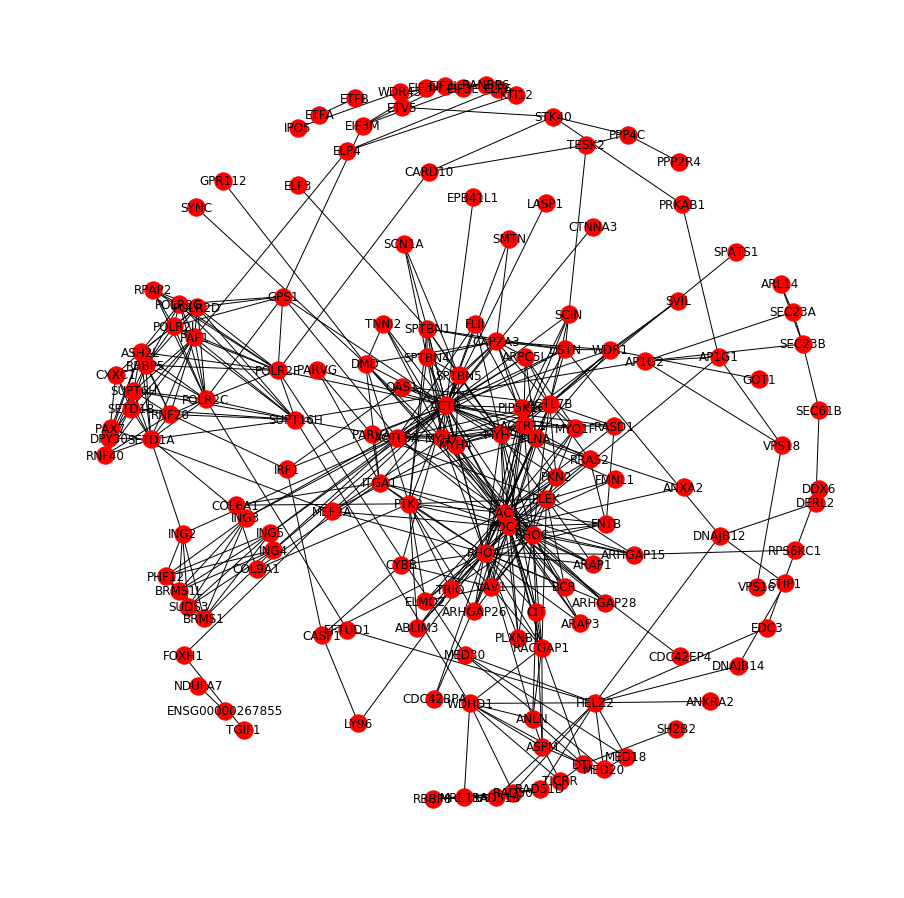

In [10]:
g = nx.from_pandas_dataframe(df, 2, 3)
plt.figure(figsize = (12, 12))
nx.draw_spring(g, with_labels=True)

#### B. Bokeh

In [11]:
#use spring layout from networkx for display
pts = nx.spring_layout(g)

TOOLS="tap,pan,wheel_zoom,reset"
p = figure(plot_width=800, plot_height=800,title = "My chart", tools=TOOLS)

sourceNode = ColumnDataSource(
    data=dict(
        x=[x[0] for x in pts.itervalues()],
        y=[x[1] for x in pts.itervalues()],
        names=[x for x in pts.iterkeys()]
    ))

sourceEdges = ColumnDataSource(
    data=dict(
        x1=[pts[x[0]][0] for x in g.edges()],
        y1=[pts[x[0]][1] for x in g.edges()],
        x2=[pts[x[1]][0] for x in g.edges()],
        y2=[pts[x[1]][1] for x in g.edges()]
    ))


cir=p.circle('x','y',source=sourceNode,radius=.01)
seg=p.segment('x1','y1','x2','y2',source=sourceEdges)


hover = HoverTool(
        tooltips=[
            ("Name", "@names"),
#            ("Screens names", "@screens"),
        ]
    )
p.add_tools(hover)

show(p)


### License

Copyright (C) 2016 University of Dundee. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.